# Fitting 2D images with Sherpa

### Introduction

Sherpa is the X-ray satellite Chandra modeling and fitting application. It enables the user to construct complex models from simple definitions and fit those models to data, using a variety of statistics and optimization methods. 
The issues of constraining the source position and morphology are common in X- and Gamma-ray astronomy. 
This notebook will show you how to apply Sherpa to CTA data.

Here we will set up Sherpa to fit the counts map and loading the ancillary images for subsequent use. A relevant test statistic for data with Poisson fluctuations is the one proposed by Cash (1979). The simplex (or Nelder-Mead) fitting algorithm is a good compromise between efficiency and robustness. The source fit is best performed in pixel coordinates.

### Necessary imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from gammapy.extern.pathlib import Path
from gammapy.data import DataStore
from gammapy.irf import EnergyDispersion
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.cube import MapMaker, PSFKernel

### Generate the required Maps

We first generate the required maps using 3 simulated runs on the Galactic center, excatly as in the analysis_3d notebook (https://github.com/gammapy/gammapy/blob/master/tutorials/analysis_3d.ipynb)

In [2]:
# Define which data to use
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps/")
obs_ids = [110380, 111140, 111159]
obs_list = data_store.obs_list(obs_ids)

In [3]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1, 1., 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

In [4]:
%%time
maker = MapMaker(geom, offset_max=4. * u.deg)
maps = maker.run(obs_list)

/Users/asinha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


CPU times: user 12.2 s, sys: 2.09 s, total: 14.3 s
Wall time: 14.3 s


### Make 2D images from 3D ones

Since sherpa image fitting works only with 2-dim images, we convert the generated maps to 2D images and save them as fits files

In [5]:
maps=maker.make_images()

In [6]:
path = Path("analysis_3d")
path.mkdir(exist_ok=True)
maps["counts"].write(str(path / "counts_2D.fits"), overwrite=True)
maps["background"].write(str(path / "background_2D.fits"), overwrite=True)
maps["exposure"].write(str(path / "exposure_2D.fits"), overwrite=True)

### Making a PSF Map

We do a little bit of jugglery to get a PSF map with one energy bin, and then convert it to a 2D image before saving it

In [7]:
# mean PSF
src_pos = SkyCoord(0, 0, unit="deg", frame="galactic")
table_psf = obs_list.make_mean_psf(src_pos)

energy_axis1 = MapAxis.from_edges(
    np.logspace(-1, 1., 2), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis1],
)

# PSF kernel used for the model convolution
psf_kernel = PSFKernel.from_table_psf(
    table_psf, geom, max_radius="0.3 deg"
)

# write PSFs
psf = np.squeeze(psf_kernel.data)
hdu_psf = fits.PrimaryHDU(psf, header=psf_kernel.psf_kernel_map.make_hdu().header)
hdu_psf.writeto(str(path / "psf_2D.fits"), overwrite=True)

### Read the maps and store them in a sherpa model

In [8]:
filecounts = str(path / "counts_2D.fits")

import sherpa.astro.ui as sh
sh.set_stat("cash")
sh.set_method("simplex")
sh.load_image(filecounts)
sh.set_coord("logical")

fileexp = str(path / "exposure_2D.fits")
filebkg = str(path / "background_2D.fits")
filepsf = str(path / "psf_2D.fits")
sh.load_table_model("expo", fileexp)
sh.load_table_model("bkg", filebkg)
sh.load_psf("psf", filepsf)

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In principle one might first want to fit the background amplitude. However the background estimation method already yields the correct normalization, so we freeze the background amplitude to unity instead of adjusting it. The (smoothed) residuals from this background model are then computed and shown.

In [9]:
sh.set_full_model(bkg)
bkg.ampl = 1
sh.freeze(bkg)

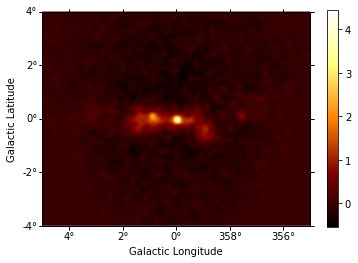

In [10]:
resid = Map.read(filecounts)
resid.data = sh.get_data_image().y - sh.get_model_image().y
resid_smooth = resid.smooth(width=4)
resid_smooth.plot(add_cbar=True);

### Find and fit the brightest source
We then find the position of the maximum in the (smoothed) residuals map, and fit a (symmetrical) Gaussian source with that initial position:

In [11]:
yp, xp = np.unravel_index(
    np.nanargmax(resid_smooth.data), resid_smooth.data.shape
)
ampl = resid_smooth.get_by_pix((xp, yp))[0]

sh.set_full_model(
    bkg + psf(sh.gauss2d.g0) * expo
)  # creates g0 as a gauss2d instance
g0.xpos, g0.ypos = xp, yp
sh.freeze(g0.xpos, g0.ypos)  # fix the position in the initial fitting step

expo.ampl = (
    1e-9
)  # fix exposure amplitude so that typical exposure is of order unity
sh.freeze(expo)
sh.thaw(g0.fwhm, g0.ampl)  # in case frozen in a previous iteration

g0.fwhm = 10  # give some reasonable initial values
g0.ampl = ampl

In [12]:
%%time
sh.fit()

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 290659
Final fit statistic   = 290645 at function evaluation 183
Data points           = 200000
Degrees of freedom    = 199998
Change in statistic   = 13.6515
   g0.fwhm        10.4874     
   g0.ampl        3.58147     
CPU times: user 9.22 s, sys: 112 ms, total: 9.33 s
Wall time: 9.34 s


Fit all parameters of this Gaussian component, fix them and re-compute the residuals map.

In [13]:
sh.thaw(g0.xpos, g0.ypos)
sh.fit()
sh.freeze(g0)

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 290645
Final fit statistic   = 290605 at function evaluation 319
Data points           = 200000
Degrees of freedom    = 199996
Change in statistic   = 40.487
   g0.fwhm        7.73583     
   g0.xpos        253.167     
   g0.ypos        197.93      
   g0.ampl        5.50011     


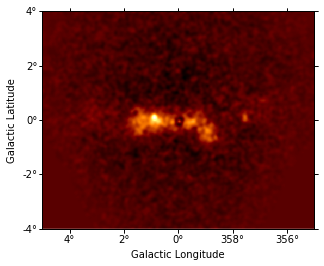

In [14]:
resid.data = sh.get_data_image().y - sh.get_model_image().y
resid_smooth = resid.smooth(width=3)
resid_smooth.plot();

### Iteratively find and fit additional sources
Instantiate additional Gaussian components, and use them to iteratively fit sources, repeating the steps performed above for component g0. (The residuals map is shown after each additional source included in the model.) This takes some time...

In [21]:
# initialize components with fixed, zero amplitude
for i in range(1, 10):
    model = sh.create_model_component("gauss2d", "g" + str(i))
    model.ampl = 0
    sh.freeze(model)

gs = [g0, g1, g2, g3, g4, g5, g6, g7, g8, g9]
sh.set_full_model(bkg + psf(g0 + g1 + g2 + g3 + g4 + g5 + g6 + g7 + g8 + g9) * expo)

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 290542
Final fit statistic   = 290412 at function evaluation 229
Data points           = 200000
Degrees of freedom    = 199998
Change in statistic   = 130.177
   g1.fwhm        28.2564     
   g1.ampl        0.492086    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 290412
Final fit statistic   = 290244 at function evaluation 382
Data points           = 200000
Degrees of freedom    = 199996
Change in statistic   = 168.729
   g1.fwhm        40.6247     
   g1.xpos        291.666     
   g1.ypos        189.24      
   g1.ampl        0.449161    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 289835
Final fit statistic   = 289331 at function evaluation 232
Data points           = 200000
Degrees of freedom    = 199998
Change in statistic   = 504

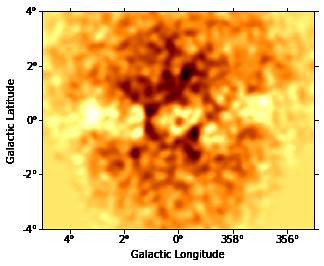

In [23]:
%%time
for i in range(1, len(gs)):
    yp, xp = np.unravel_index(
        np.nanargmax(resid_smooth.data), resid_smooth.data.shape
    )
    ampl = resid_smooth.get_by_pix((xp, yp))[0]
    gs[i].xpos, gs[i].ypos = xp, yp
    gs[i].fwhm = 10
    gs[i].ampl = ampl

    sh.thaw(gs[i].fwhm)
    sh.thaw(gs[i].ampl)
    sh.fit()

    sh.thaw(gs[i].xpos)
    sh.thaw(gs[i].ypos)
    sh.fit()
    sh.freeze(gs[i])

    resid.data = sh.get_data_image().y - sh.get_model_image().y
    resid_smooth = resid.smooth(width=6)

(<matplotlib.figure.Figure at 0x1810818ba8>,
 <matplotlib.colorbar.Colorbar at 0x1811f9d7f0>)

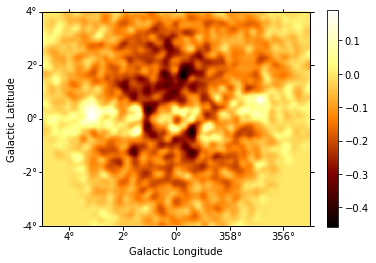

In [25]:
resid_smooth.plot(add_cbar=True)

### Generating output table and Test Statistics estimation
When adding a new source, one needs to check the significance of this new source. A frequently used method is the Test Statistics (TS). This is done by comparing the change of statistics when the source is included compared to the null hypothesis (no source ; in practice here we fix the amplitude to zero).

$TS = Cstat(source) - Cstat(no source)$

The criterion for a significant source detection is typically that it should improve the test statistic by at least 25 or 30. The last excess fitted (g9) thus not a significant source:

In [27]:
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import Table

rows = []
for g in gs:
    ampl = g.ampl.val
    g.ampl = 0
    stati = sh.get_stat_info()[0].statval
    g.ampl = ampl
    statf = sh.get_stat_info()[0].statval
    delstat = stati - statf

    geom = resid.geom
    coord = geom.pix_to_coord((g.xpos.val, g.ypos.val))
    pix_scale = geom.pixel_scales.mean().deg
    sigma = g.fwhm.val * pix_scale * gaussian_fwhm_to_sigma
    rows.append(
        dict(delstat=delstat, glon=coord[0], glat=coord[1], sigma=sigma)
    )

table = Table(rows=rows, names=rows[0])
for name in table.colnames:
    table[name].format = ".5g"
table

delstat,glon,glat,sigma
float64,float64,float64,float64
828.81,359.93,-0.031395,0.065702
159.87,359.16,-0.20519,0.34503
508.71,0.98303,-0.028162,0.33178
71.151,0.24638,-0.044533,0.1811
51.756,359.6,-0.057564,0.11515
75.217,0.84488,0.11608,0.024493
55.867,358.81,-0.57964,0.16104
70.805,357.51,0.10443,0.071566
59.495,1.5858,-0.15886,0.19758


### Exercises

1. Use other morphologies for the sources (eg: disk, shell) rather than only Gaussian.
2. Compare the TS between different models

### More about sherpa

These are good resources to learn more about Sherpa:

* https://python4astronomers.github.io/fitting/fitting.html
* https://github.com/DougBurke/sherpa-standalone-notebooks

You could read over the examples there, and try to apply a similar analysis to this dataset here to practice.

If you want a deeper understanding of how Sherpa works, then these proceedings are good introductions:

* http://conference.scipy.org/proceedings/scipy2009/paper_8/full_text.pdf
* http://conference.scipy.org/proceedings/scipy2011/pdfs/brefsdal.pdf